In [1]:
!pip install gdown
!gdown --id 1NrrWVThGgyC-XYFA6qp4tLxarQXETsbB

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1NrrWVThGgyC-XYFA6qp4tLxarQXETsbB
From (redirected): https://drive.google.com/uc?id=1NrrWVThGgyC-XYFA6qp4tLxarQXETsbB&confirm=t&uuid=865e4992-2029-4e0b-a573-0695bf88e961
To: /kaggle/working/dataset.zip
100%|███████████████████████████████████████| 2.87G/2.87G [00:27<00:00, 104MB/s]


In [2]:
!unzip /kaggle/working/dataset.zip

Archive:  /kaggle/working/dataset.zip
   creating: dataset/
   creating: dataset/x/
  inflating: dataset/x/cat1.jpg      
  inflating: dataset/x/cat10.jpg     
  inflating: dataset/x/cat100.jpg    
  inflating: dataset/x/cat1000.jpg   
  inflating: dataset/x/cat1001.jpg   
  inflating: dataset/x/cat1002.jpg   
  inflating: dataset/x/cat1003.jpg   
  inflating: dataset/x/cat1004.jpg   
  inflating: dataset/x/cat1005.jpg   
  inflating: dataset/x/cat1006.jpg   
  inflating: dataset/x/cat1007.jpg   
  inflating: dataset/x/cat1008.jpg   
  inflating: dataset/x/cat1009.jpg   
  inflating: dataset/x/cat101.jpg    
  inflating: dataset/x/cat1010.jpg   
  inflating: dataset/x/cat1011.jpg   
  inflating: dataset/x/cat1012.jpg   
  inflating: dataset/x/cat1013.jpg   
  inflating: dataset/x/cat1014.jpg   
  inflating: dataset/x/cat1015.jpg   
  inflating: dataset/x/cat1016.jpg   
  inflating: dataset/x/cat1017.jpg   
  inflating: dataset/x/cat1018.jpg   
  inflating: dataset/x/cat1019.jpg   
  in

In [3]:
import os 
import torch 
import numpy as np
from torch import nn 
from tqdm import tqdm
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
inputs = []
outputs = [] 

x = sorted(os.listdir("/kaggle/working/dataset/y"))
y = sorted(os.listdir("/kaggle/working/dataset/x"))

for i, o in zip(x, y): 
    input_img = os.path.join("/kaggle/working/dataset/y", i)
    output_img = os.path.join("/kaggle/working/dataset/x", o)
    
    inputs.append(input_img)
    outputs.append(output_img)

dataset = pd.DataFrame({"input":inputs, "output":outputs})
dataset.head()

,input,output
0,/kaggle/working/dataset/y/cat_erased1.jpg,/kaggle/working/dataset/x/cat1.jpg
1,/kaggle/working/dataset/y/cat_erased10.jpg,/kaggle/working/dataset/x/cat10.jpg
2,/kaggle/working/dataset/y/cat_erased100.jpg,/kaggle/working/dataset/x/cat100.jpg
3,/kaggle/working/dataset/y/cat_erased1000.jpg,/kaggle/working/dataset/x/cat1000.jpg
4,/kaggle/working/dataset/y/cat_erased1001.jpg,/kaggle/working/dataset/x/cat1001.jpg


In [5]:
train, valid = train_test_split(dataset, test_size=0.1)
print(len(train))
print(len(valid))

8997
1000


In [6]:
class CatsDataset(Dataset): 
    def __init__(self, image_dataframe, transform): 
        self.image_dataframe = image_dataframe
        self.transform = transform 
    
    def __len__(self):
        return len(self.image_dataframe)
    
    def __getitem__(self, idx):
        input_image = self.image_dataframe.iloc[idx, 0]
        x = Image.open(input_image)
        
        output_image = self.image_dataframe.iloc[idx, 1]
        y = Image.open(output_image)
        
        if self.transform: 
            x = self.transform(x)
            y = self.transform(y)
        
        return x, y

In [7]:
to_tensor = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

In [8]:
train_dataset = CatsDataset(train, to_tensor)
valid_dataset = CatsDataset(valid, to_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

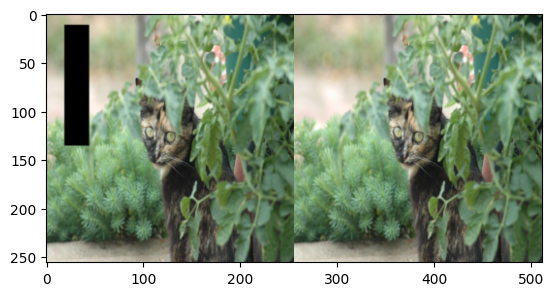

In [9]:
img, label = next(iter(train_loader))
img_sample = img[0].permute(1,2,0)
label_sample = label[0].permute(1,2,0)

show_sample = np.concatenate([img_sample.numpy(), label_sample.numpy()], axis=1)
plt.imshow(show_sample)
plt.show()

# Model

In [10]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential( 
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.bottleneck = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.latent_space = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=3, padding=1)

        
    def forward(self, x):
        x = self.encoder(x) 
        encoded = F.relu(self.bottleneck(x))
        latent_space = F.sigmoid(self.latent_space(encoded)) #for visualization
        return encoded, latent_space

    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2), 
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2), 
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.decoder(x)
        return x
    

class AutoEncoder(nn.Module):
    def __init__(self, encoder:nn.Module, decoder:nn.Module):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        x, _ = self.encoder(x)
        x = self.decoder(x)
        return x 

In [11]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)

autoencoder = AutoEncoder(encoder, decoder)

In [12]:
# Forward pass test 
sample, _ = next(iter(train_loader))
input_img = sample[0].unsqueeze(dim=0).to(device)

with torch.inference_mode():
    encoded, latent = encoder(input_img)
    decoded = decoder(encoded)
    autoencoder_out = autoencoder(input_img)
    
print(encoded.size())
print(latent.size())
print(decoded.size())
print(autoencoder_out.size())

torch.Size([1, 256, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


# Optimizer & Loss

In [13]:
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=0.005)
loss_fn = nn.MSELoss()

In [14]:
train_losses = []
val_losses = []

epochs = 10

for epoch in range(1, epochs+1):
    running_train_loss = 0.0
    for i, (x,y) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch}/{epochs}', unit='batch')):
        x, y = x.to(device), y.to(device)
        
        # Forward pass
        outputs = autoencoder(x)
        loss = loss_fn(outputs, y)

        optimizer.zero_grad(); loss.backward(); optimizer.step()
        running_train_loss += loss.item()
    
    avg_train_loss = running_train_loss/len(train_loader) 
    train_losses.append(avg_train_loss)
    
    #### Validation ####              
    autoencoder.eval()
    running_val_loss = 0.0 
    for i, (x,y) in enumerate(valid_loader):
        x, y = x.to(device), y.to(device)
        outputs = autoencoder(x)
        val_loss = loss_fn(outputs, y)
        running_val_loss += val_loss.item()
    
    avg_val_loss = running_val_loss/len(valid_loader)
    val_losses.append(avg_val_loss)
    
    print(f"train loss: {avg_train_loss} | validation loss: {avg_val_loss}")

Epoch 1/10: 100%|██████████| 563/563 [02:37<00:00,  3.57batch/s]


train loss: 0.008579089998169993 | validation loss: 0.005215725011473138


Epoch 2/10: 100%|██████████| 563/563 [02:37<00:00,  3.57batch/s]


train loss: 0.003952767891845737 | validation loss: 0.003804067936947658


Epoch 3/10: 100%|██████████| 563/563 [02:36<00:00,  3.61batch/s]


train loss: 0.0032013742092725545 | validation loss: 0.0029612158643200046


Epoch 4/10: 100%|██████████| 563/563 [02:36<00:00,  3.60batch/s]


train loss: 0.0035764576818009914 | validation loss: 0.0029994320967012926


Epoch 5/10: 100%|██████████| 563/563 [02:36<00:00,  3.61batch/s]


train loss: 0.002727476959356618 | validation loss: 0.0031111034017706676


Epoch 6/10: 100%|██████████| 563/563 [02:35<00:00,  3.61batch/s]


train loss: 0.0026040253455653045 | validation loss: 0.0029480260822715033


Epoch 7/10: 100%|██████████| 563/563 [02:35<00:00,  3.62batch/s]


train loss: 0.002529905077159325 | validation loss: 0.004440837927783529


Epoch 8/10: 100%|██████████| 563/563 [02:34<00:00,  3.64batch/s]


train loss: 0.0025135318680003047 | validation loss: 0.0027592811707614195


Epoch 9/10: 100%|██████████| 563/563 [02:34<00:00,  3.63batch/s]


train loss: 0.0024222348077259097 | validation loss: 0.002874984112124713


Epoch 10/10: 100%|██████████| 563/563 [02:34<00:00,  3.64batch/s]


train loss: 0.002417187013110844 | validation loss: 0.0024640740058015265


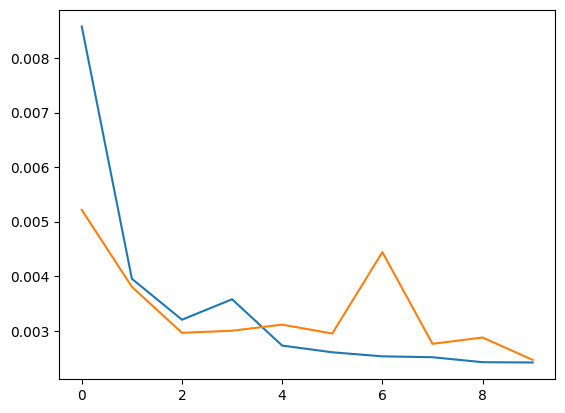

In [15]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

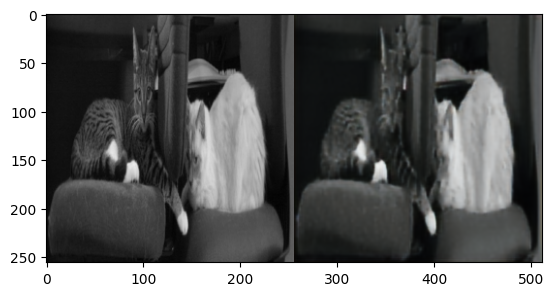

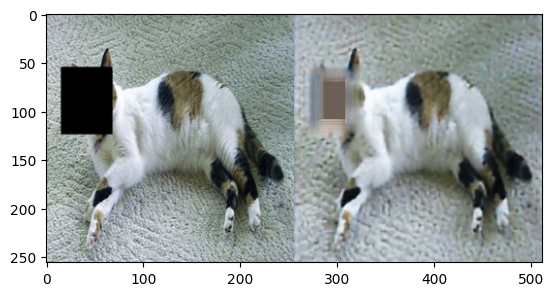

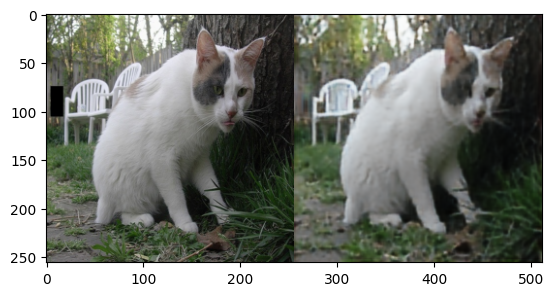

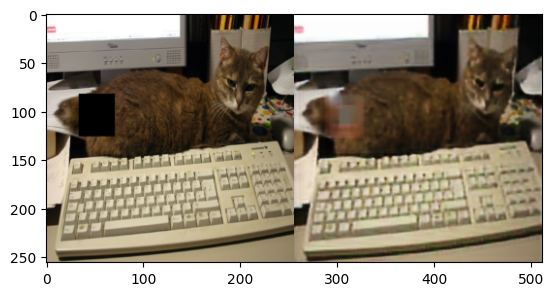

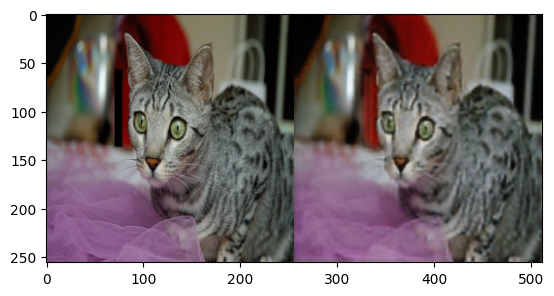

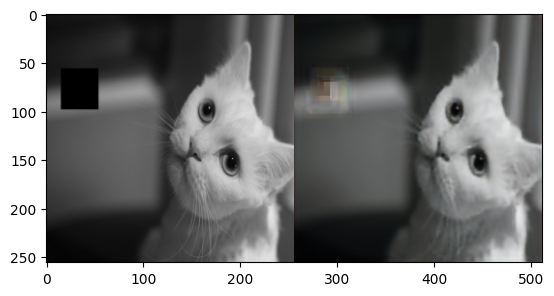

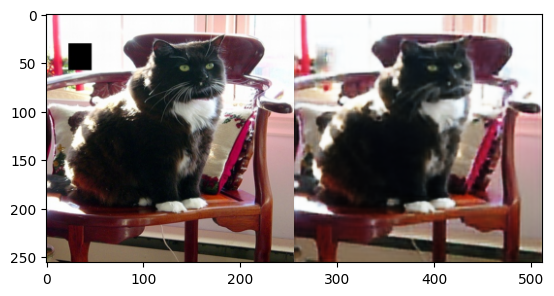

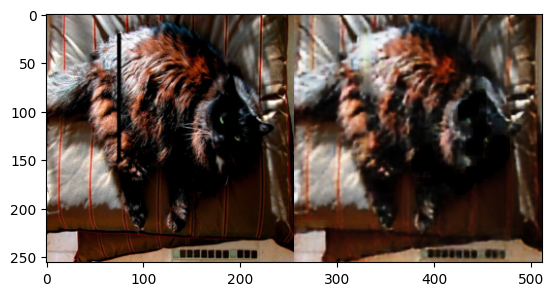

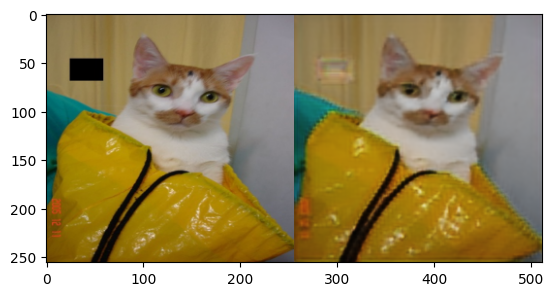

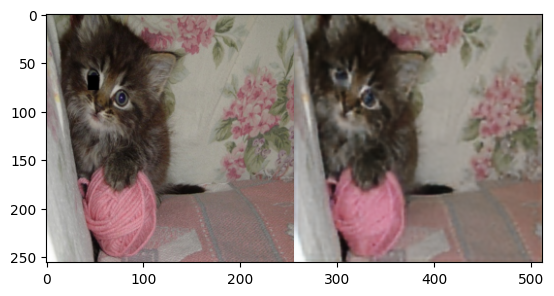

In [16]:
image, label = next(iter(train_loader))
image = image[0:10]

autoencoder.eval()
for i, img in enumerate(image, 0):
    x = img.unsqueeze(dim=0).to(device)
    with torch.inference_mode():
        y = autoencoder(x)
        
    reconstructed = y.squeeze(dim=0).permute(1,2,0).cpu().numpy()
    input_img = img.permute(1,2,0).cpu().numpy()
    
    gabung = np.concatenate([input_img, reconstructed], axis=1) 
    plt.imshow(gabung)
    plt.show()